# Extended overview figures

This notebook creates the extended overview plots from the SI information of the publication.

In [2]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Netherlands","Italy","Czechia","Belgium","Austria"]
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+                    
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/share/soccer_project/covid_uefa_traces14/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(500, 1000, 12)):
        try: 
            model, trace = load(fstr(500, 1000, 12))
            print(f"Use 1000 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(900, 800, 99), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 1000 sample runs for England
Use 1000 sample runs for Scotland
Use 1000 sample runs for Germany
Use 1000 sample runs for France
Use 1000 sample runs for Spain
Use 1000 sample runs for Slovakia
Use 1000 sample runs for Portugal
Use 1000 sample runs for Netherlands
Use 1000 sample runs for Italy
Use 1000 sample runs for Czechia
Use 1000 sample runs for Belgium
Use 1000 sample runs for Austria


/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


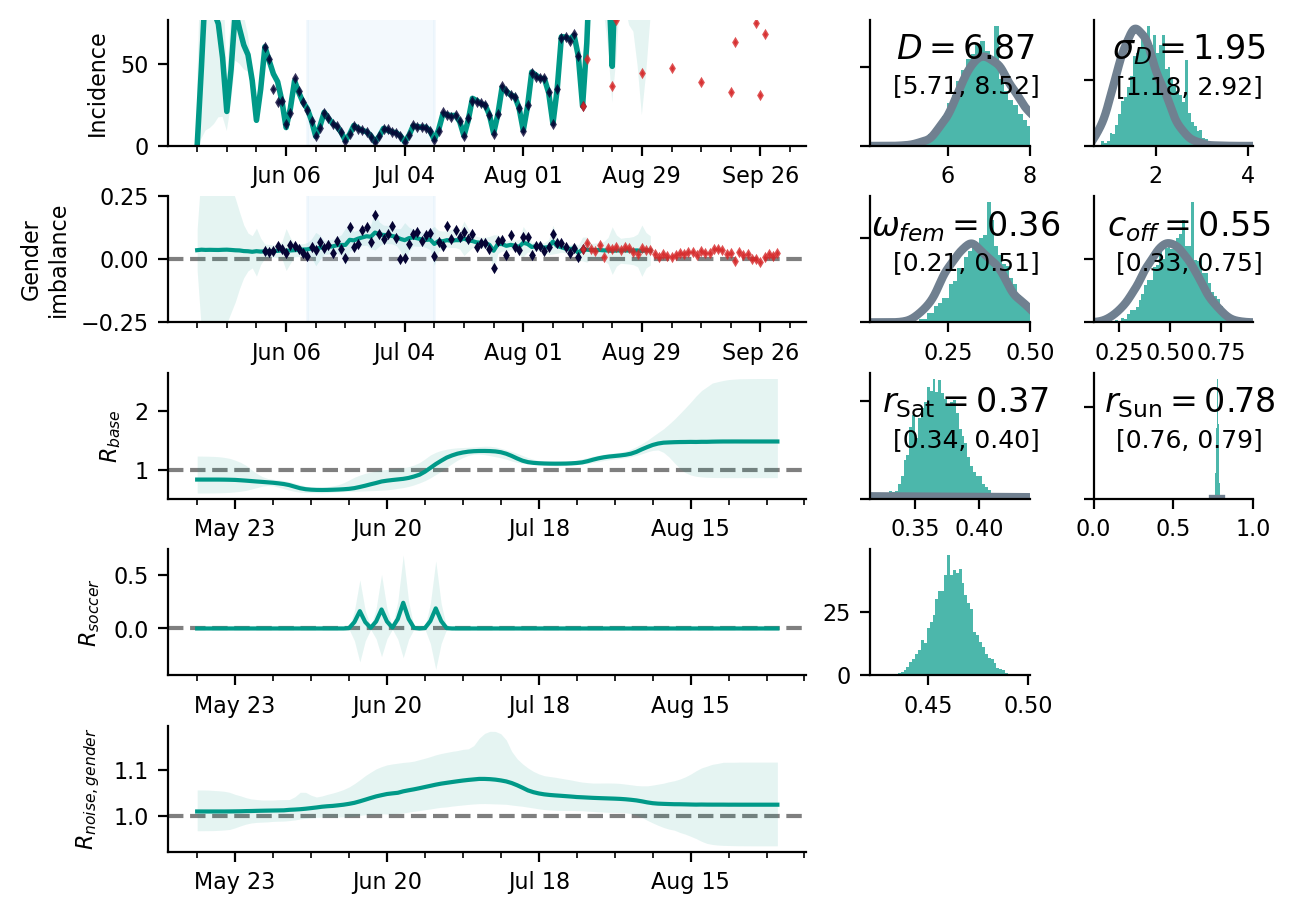

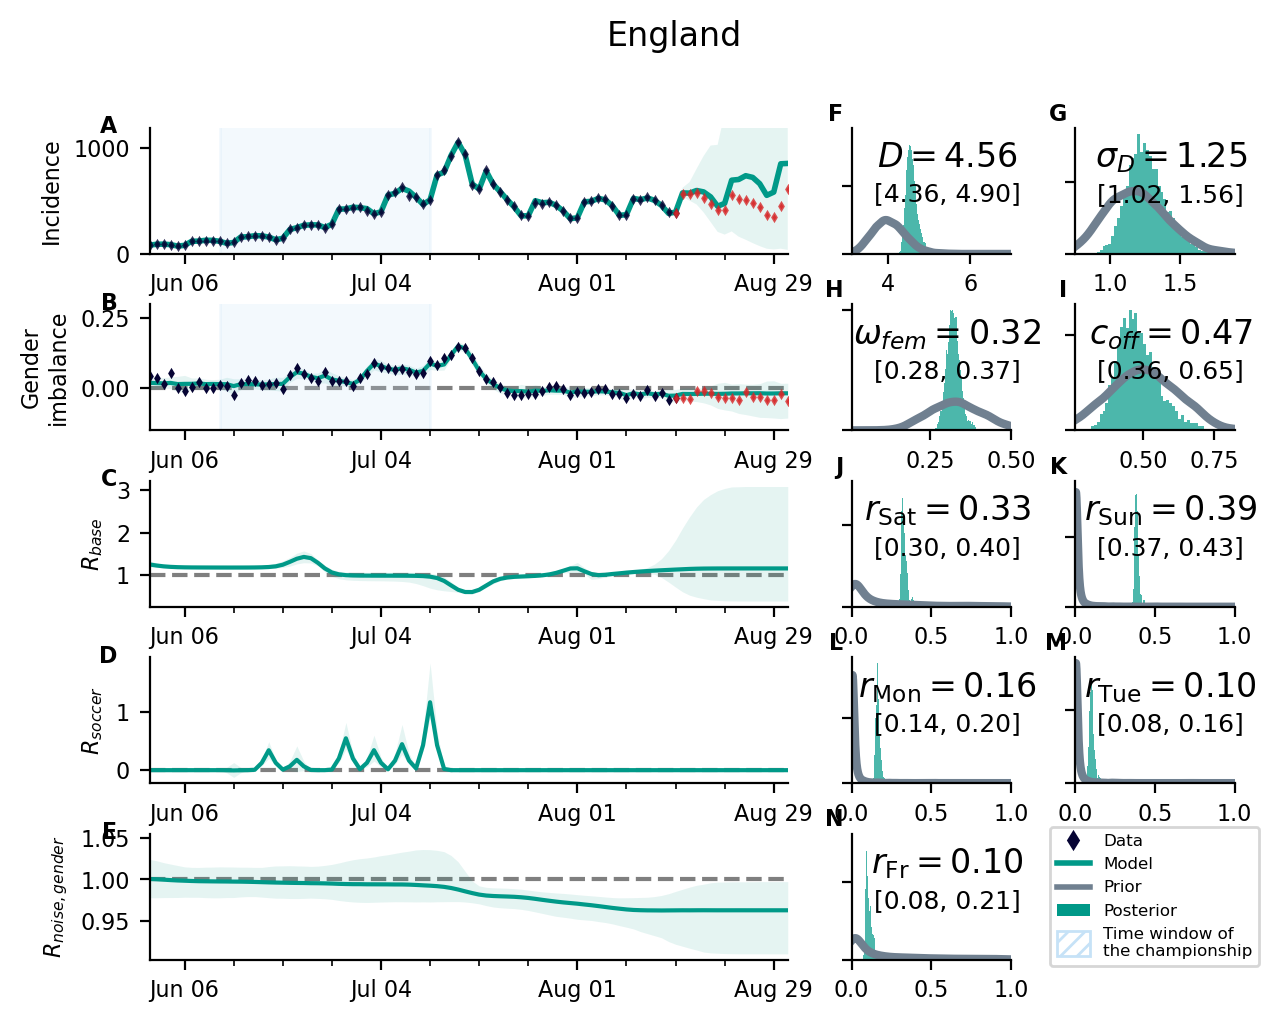

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


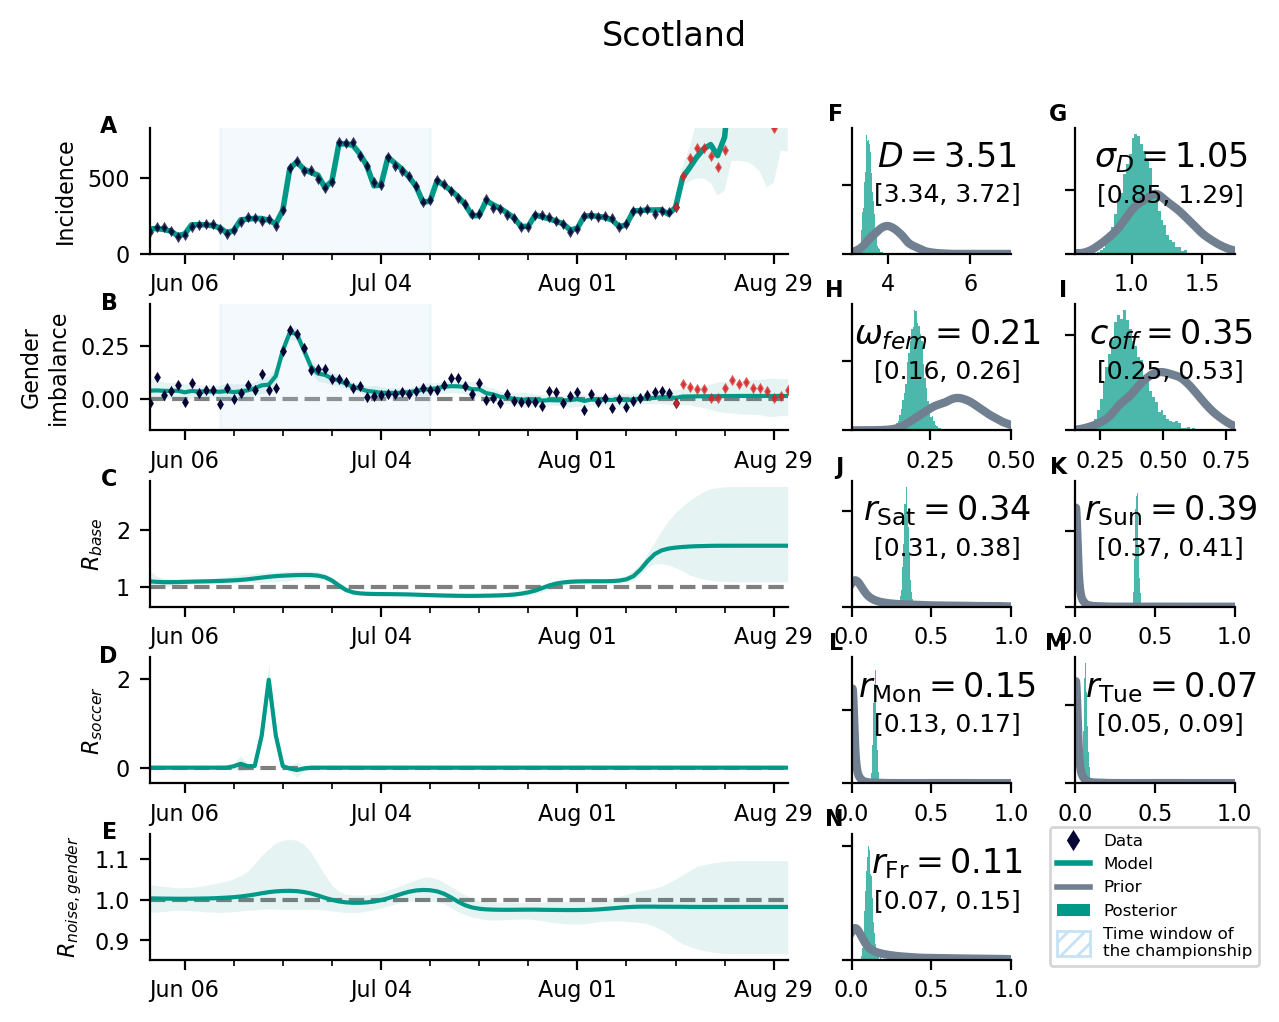

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


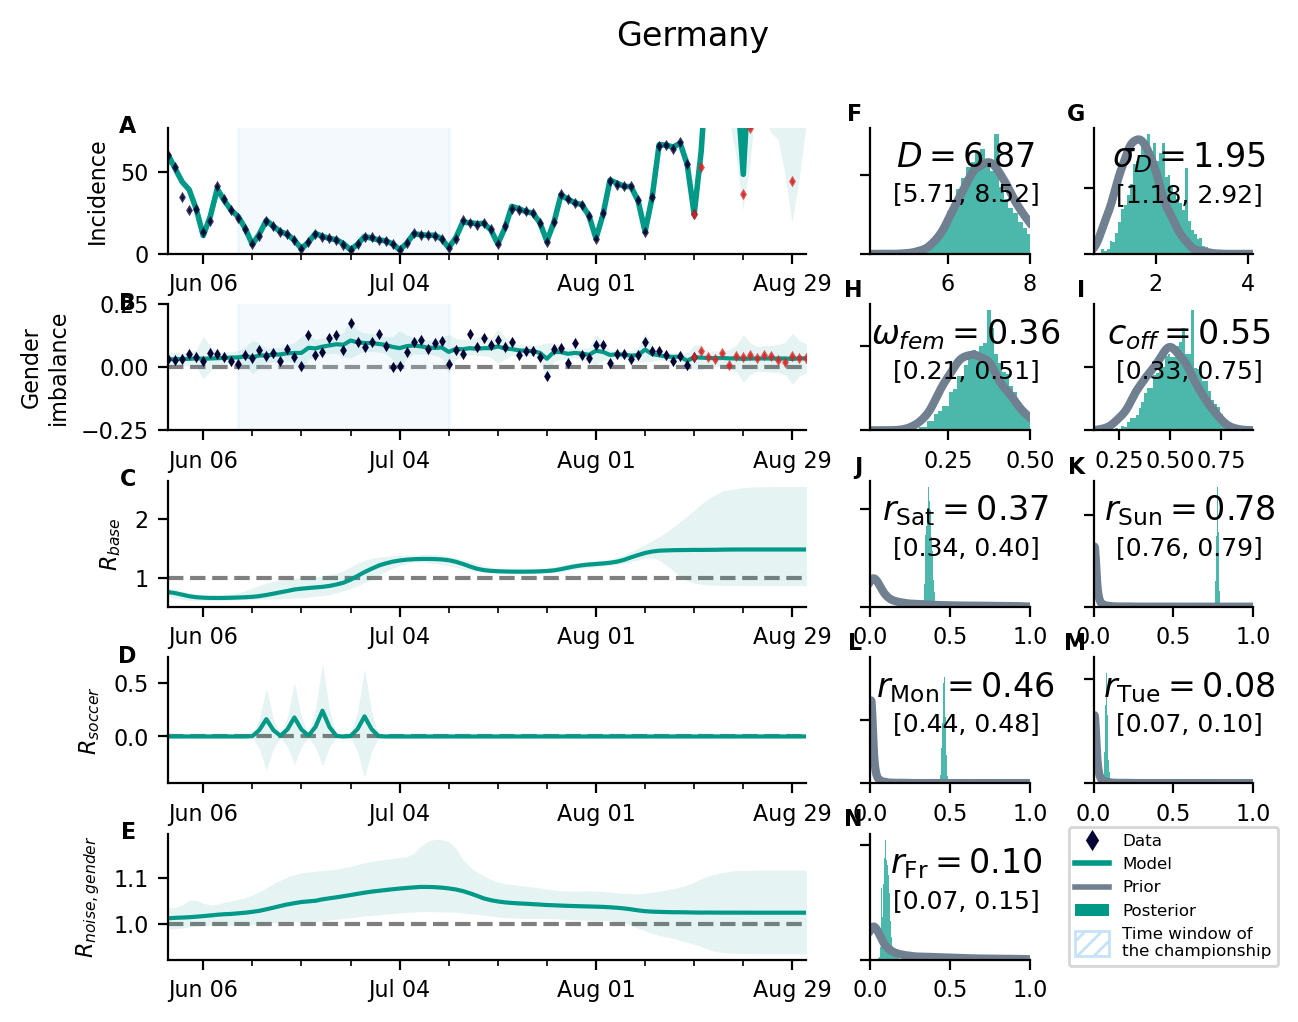

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


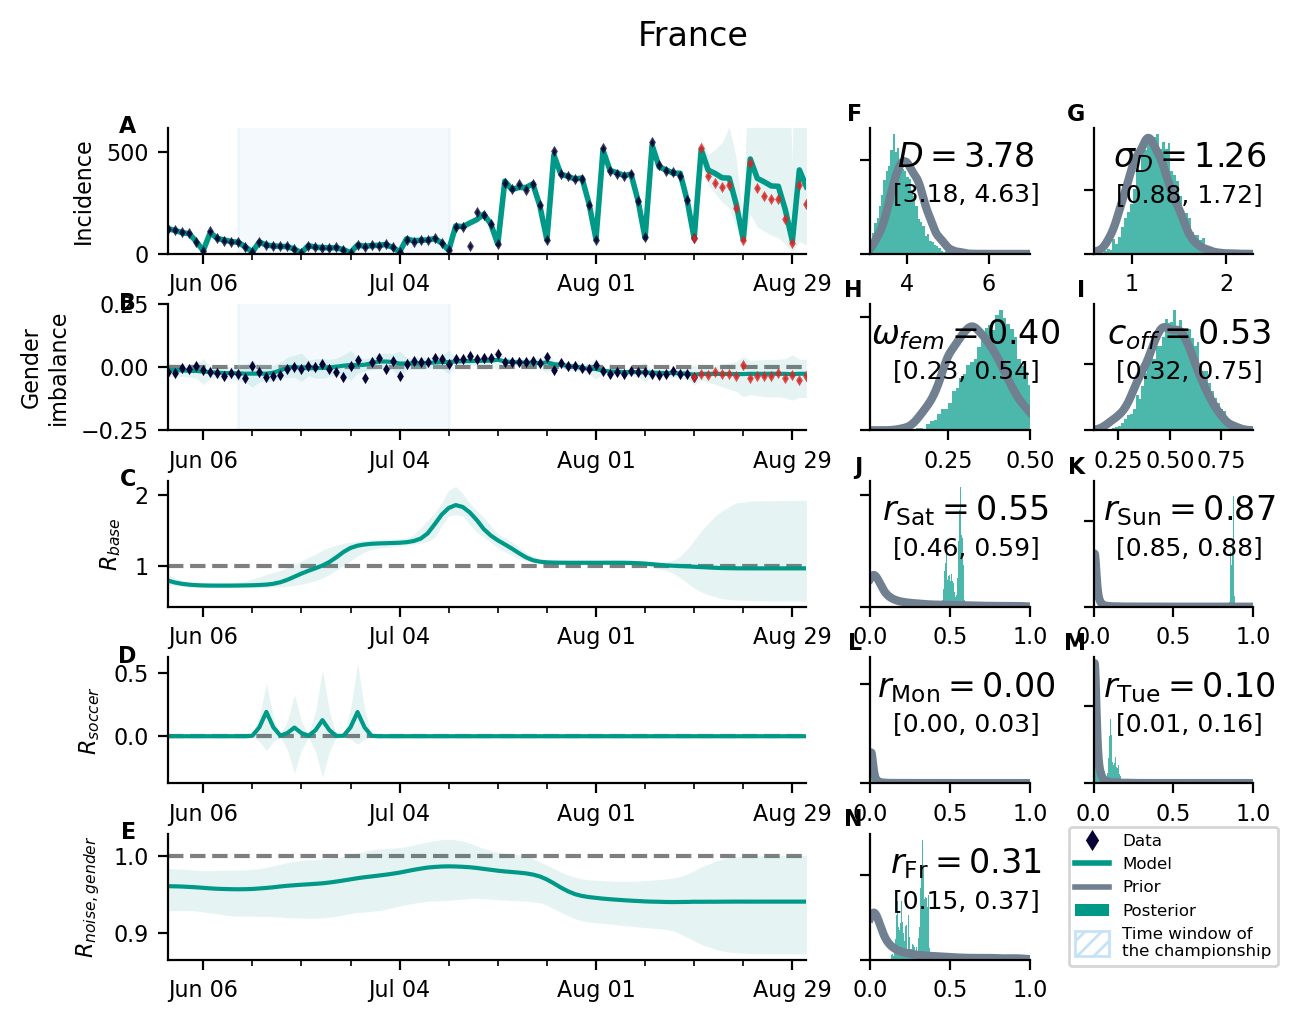

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


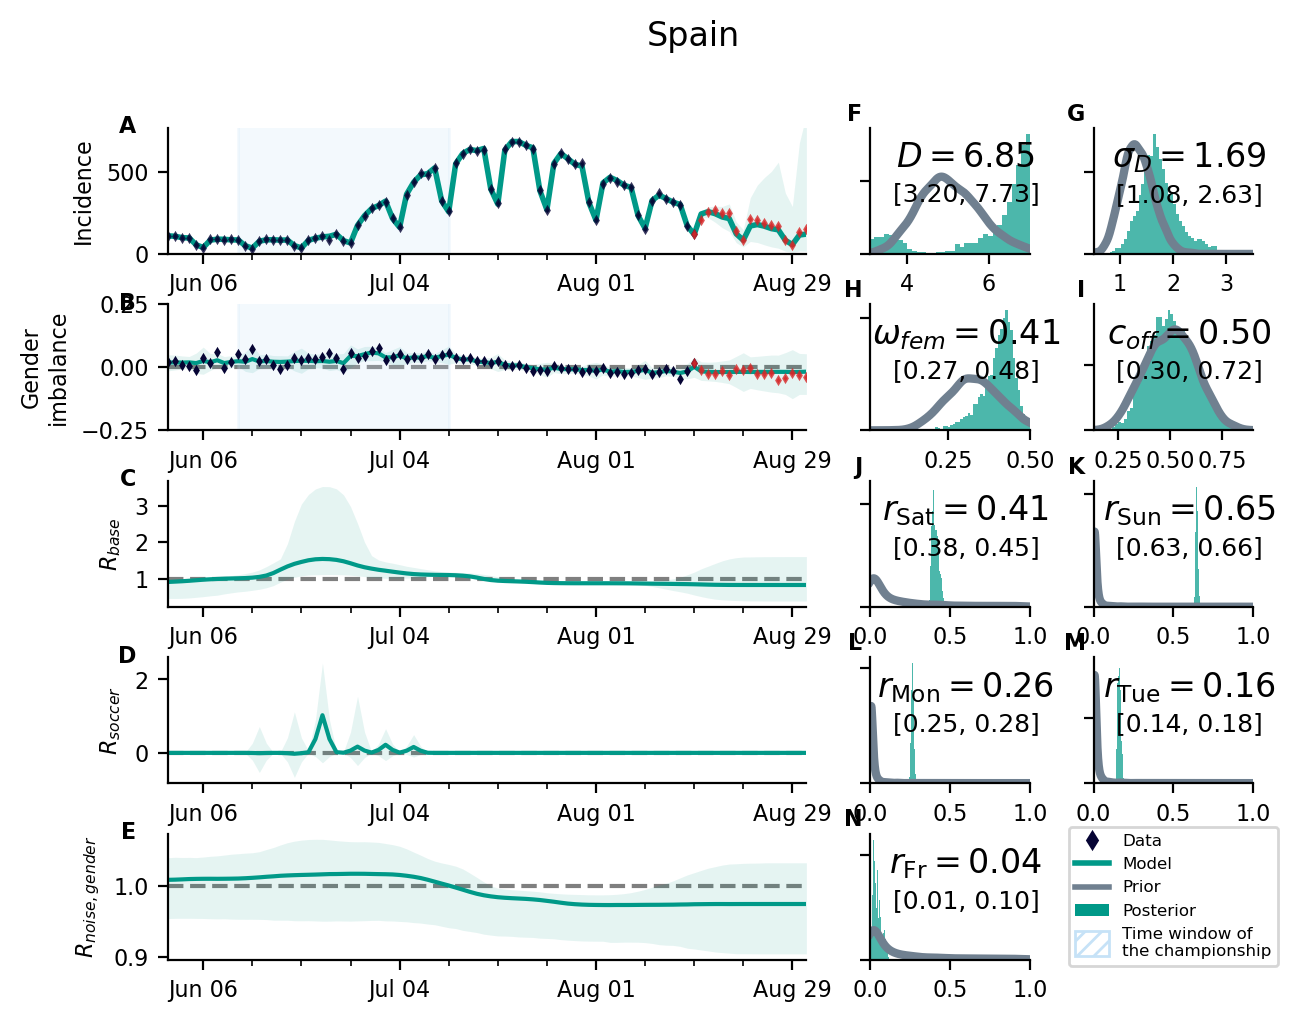

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


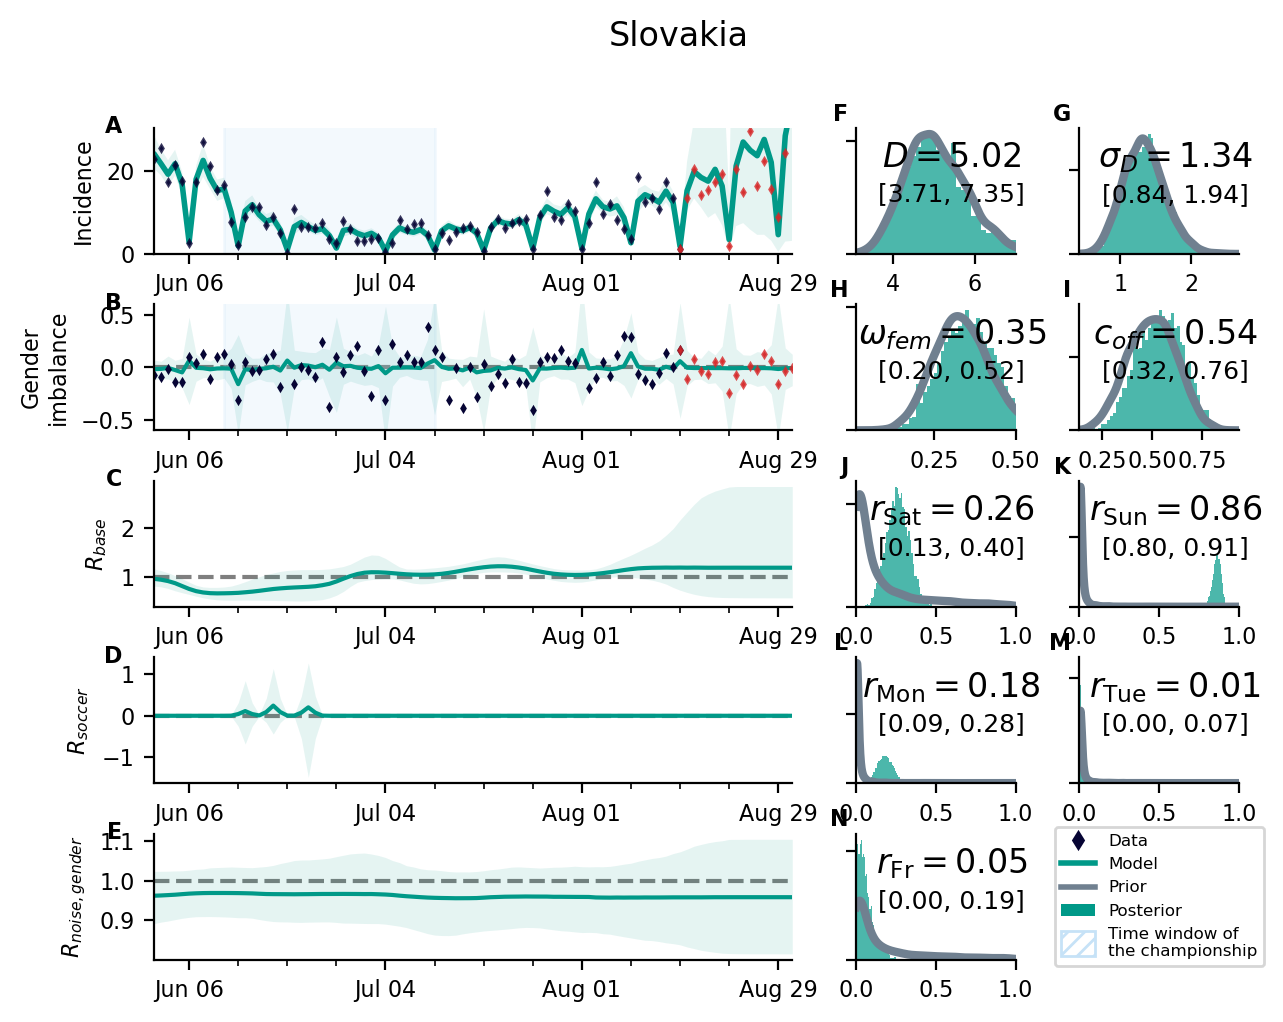

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


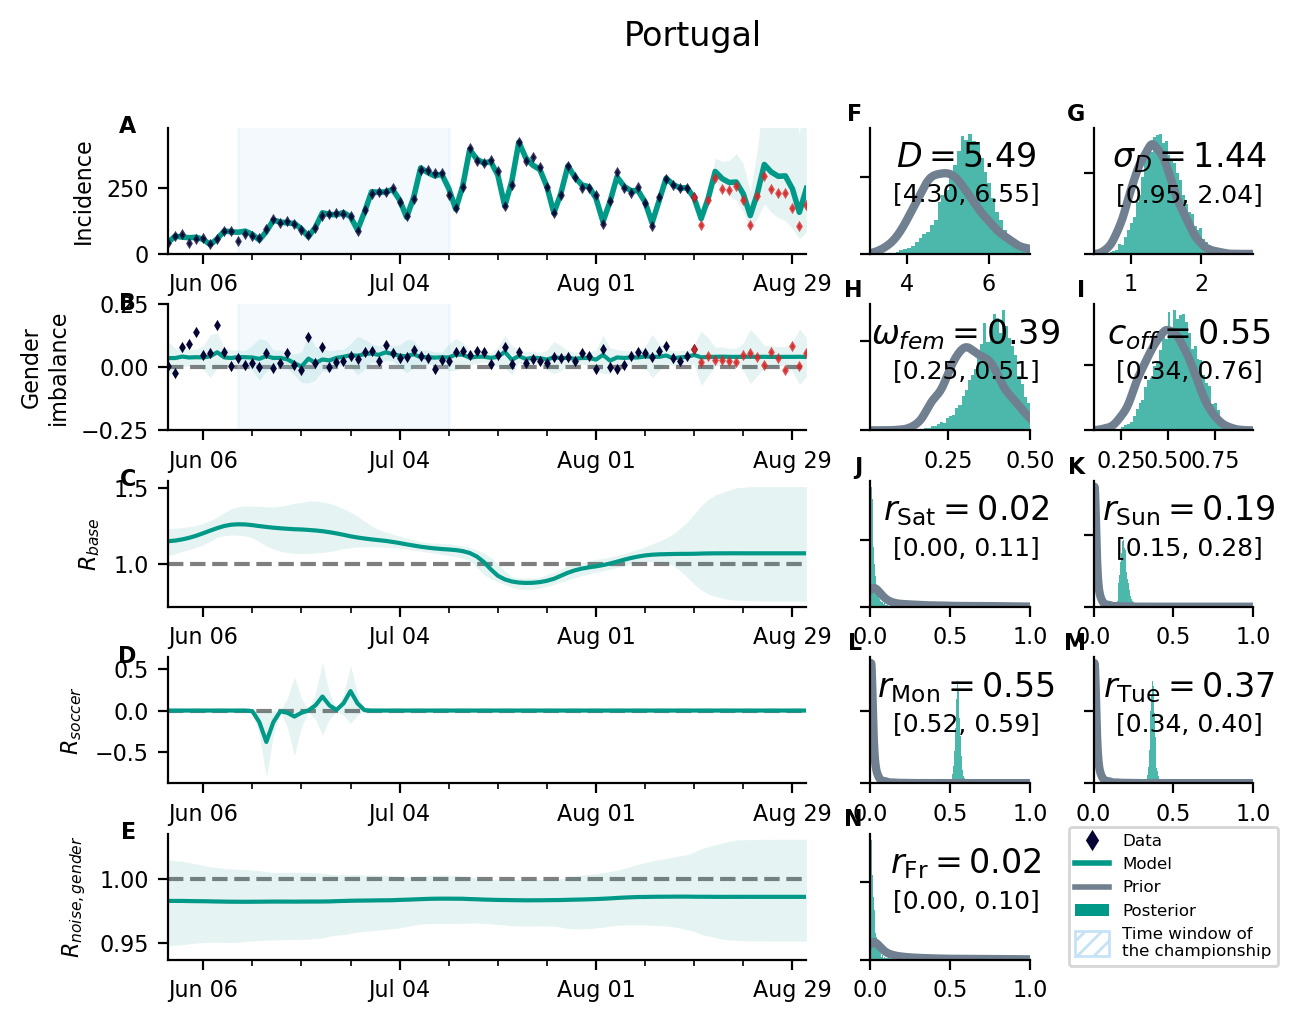

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


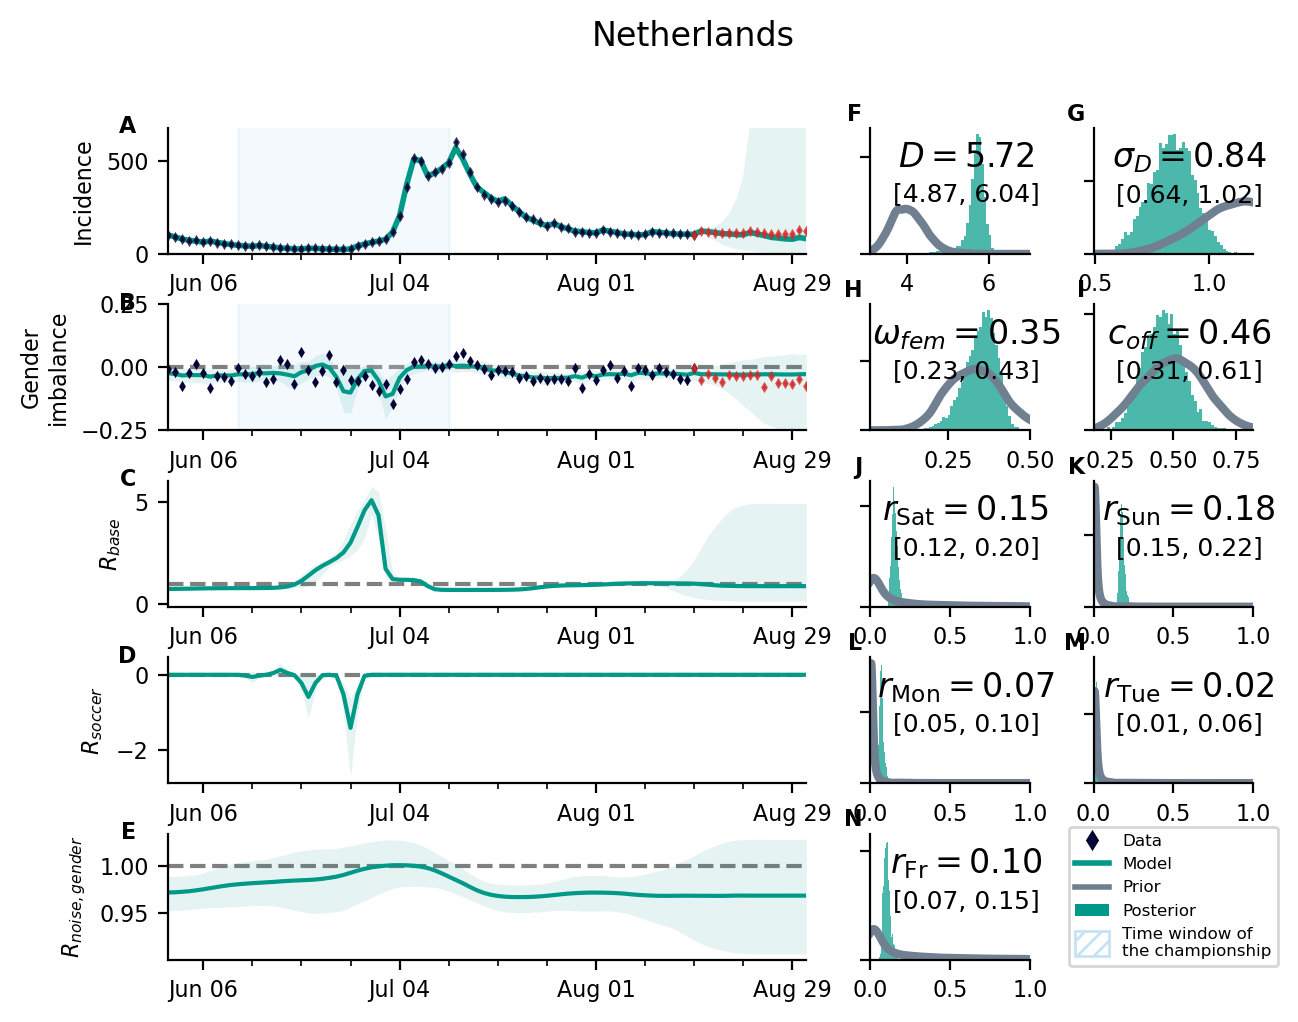

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:146: RuntimeWarning: invalid value encountered in true_divide
  y=(
/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:171: RuntimeWarning: invalid value encountered in true_divide
  imbalance = (
/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


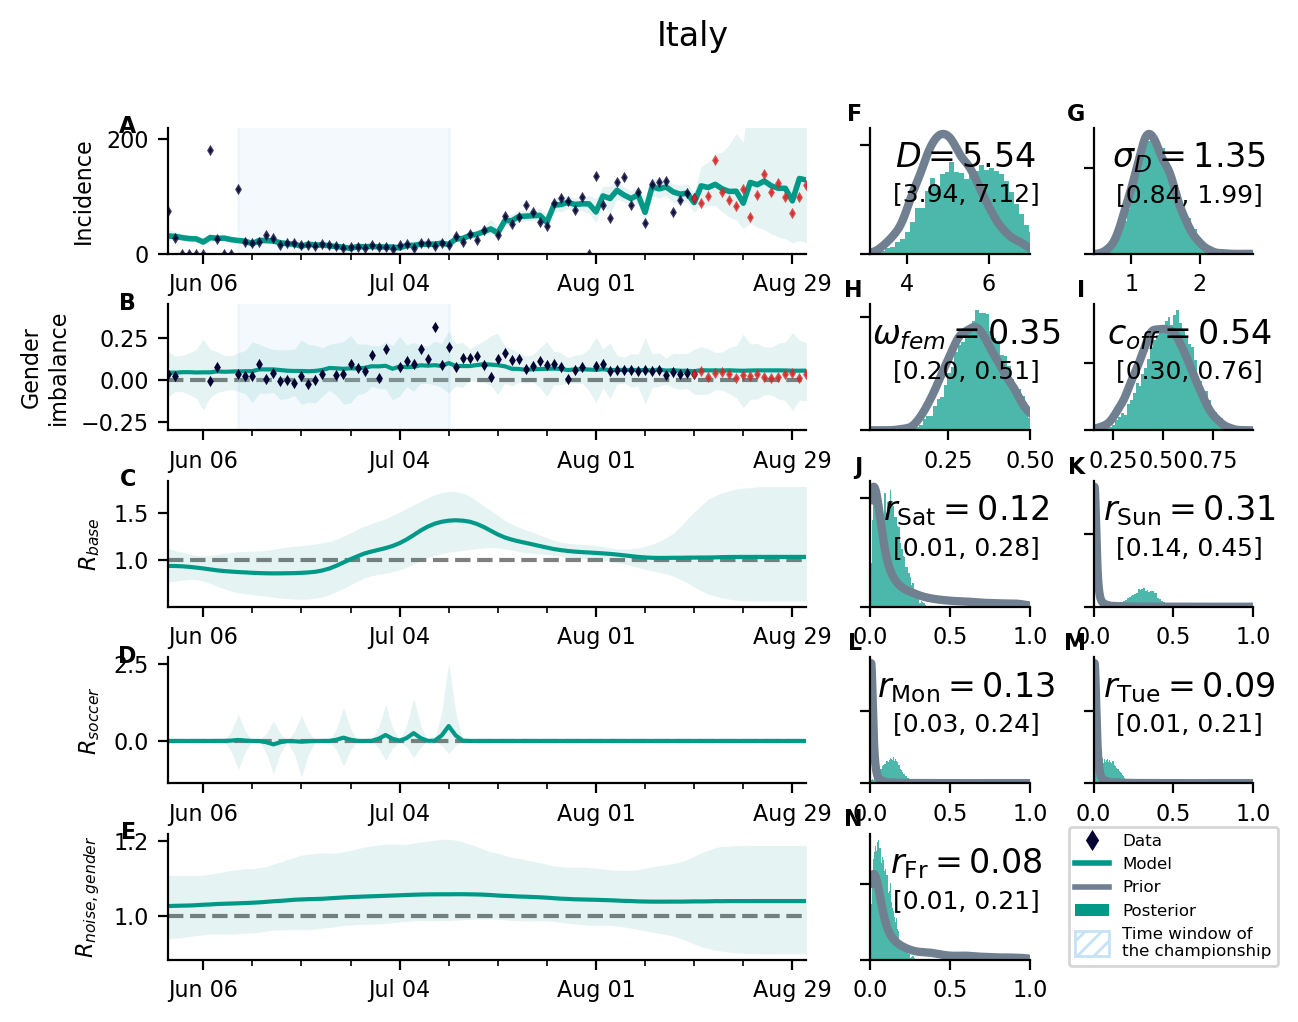

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


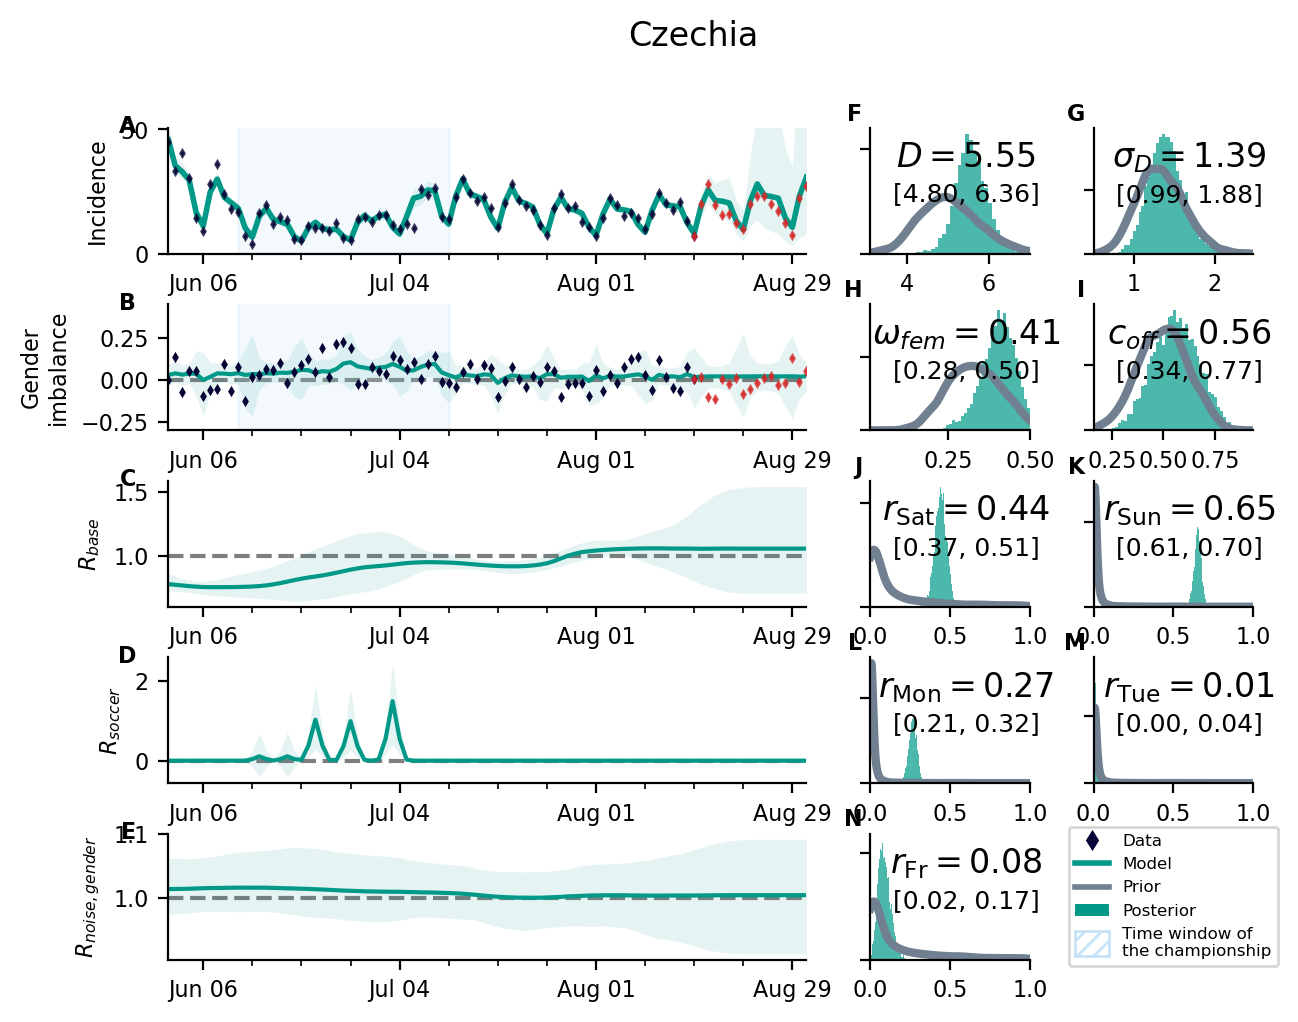

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


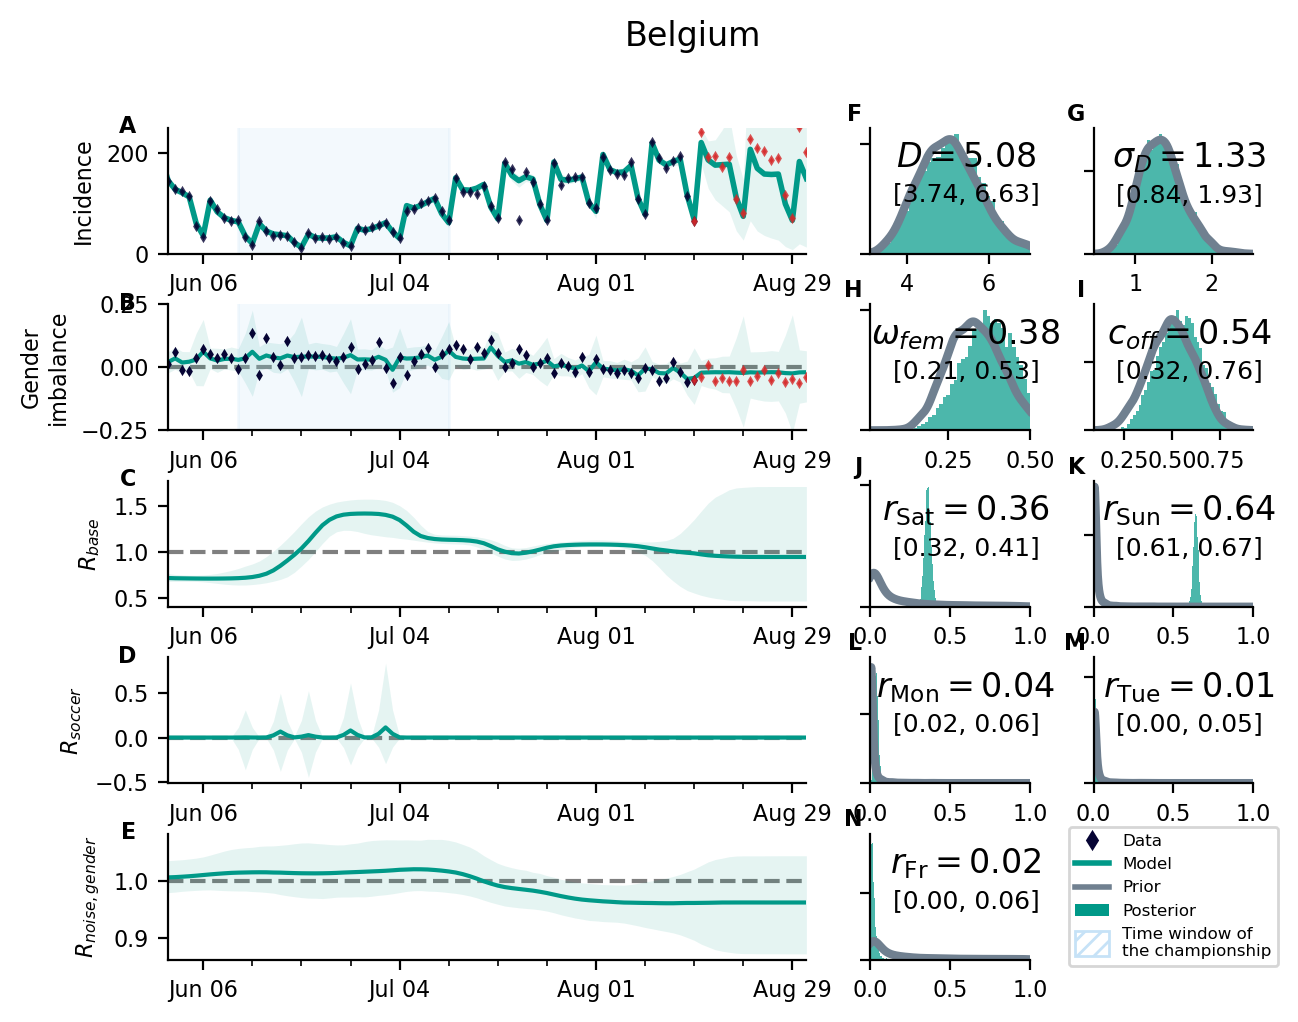

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:925: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


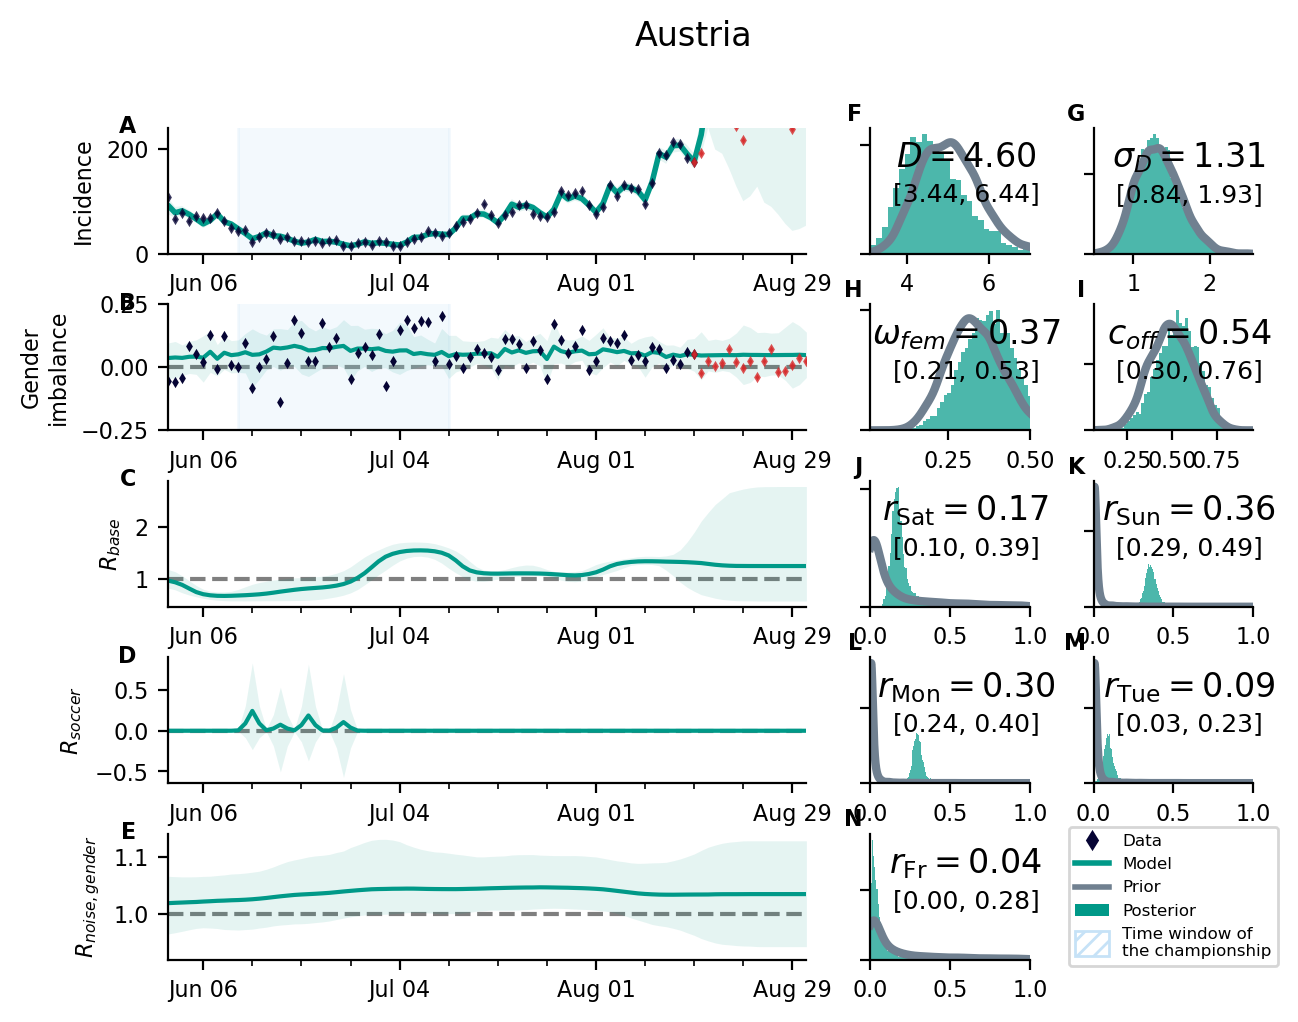

In [15]:
from covid19_soccer.plot.overview import single_extended,single_extended_v2

country2ylim_inbalance = {
    "England": [-0.15,0.3],
    "Scotland": [-0.15,0.45],
    "Slovakia": [-0.6,0.6],
    "Italy": [-0.3,0.45],
    "Czechia": [-0.3,0.45]
}

for trace,model,dl in zip(traces,models,dls):

    country = dl.countries[0]
    
    if  country in country2ylim_inbalance:
        ylim_imbalance = country2ylim_inbalance[country]
    else:
        ylim_imbalance = [-0.25,0.25]
    
    if country == "Italy":
        ylim_incidence=[0,220]
    else:
        ylim_incidence=None
    
    fig0 = single_extended_v2(trace, model, dl, ylim_imbalance=ylim_imbalance,ylim_incidence=ylim_incidence)

    fig0.suptitle(f"{dl.countries[0]}")

    plt.show()
    #fig0.savefig(f"../figures/other_countries/extended_overview_{dl.countries[0]}.pdf", **save_kwargs)
    #fig0.savefig(f"../figures/other_countries/extended_overview_{dl.countries[0]}.png", **save_kwargs)
    plt.close(fig=fig0)

Country	2.5	50.0	97.5	>0
England0	6.460633008462413	9.2487157724292	14.464994007054532	1.0
Czechia9	3.1613046874514934	8.594296178432803	13.236053320073207	0.999125
Spain4	-1.0122422687187265	3.0892778786686494	8.513217369113898	0.9335
Italy8	-8.074975343138325	2.8620702796510464	12.567263439458458	0.7214303575893973
Scotland1	1.7861824224058833	2.5888660259049603	3.4933138134957726	1.0
Slovakia5	-6.237517675553159	1.8050101464075239	8.66803316191339	0.7211020663744521
Germany2	-2.140411873901196	1.7903512383209828	4.3923356711578325	0.86375
Austria11	-2.7700567919418915	1.5579275435291957	6.018825520227528	0.784875
France3	-0.6075167356506312	1.1223343825883725	2.8530681881026068	0.903125
Belgium10	-2.4034075034017275	0.6483775435382731	4.323572269308892	0.68125
Portugal6	-2.36740133779791	0.22505916374320245	2.2663397363226077	0.59625
Netherlands7	-2.3228012181036806	-1.2166021049011182	-0.4131869886484283	0.0015


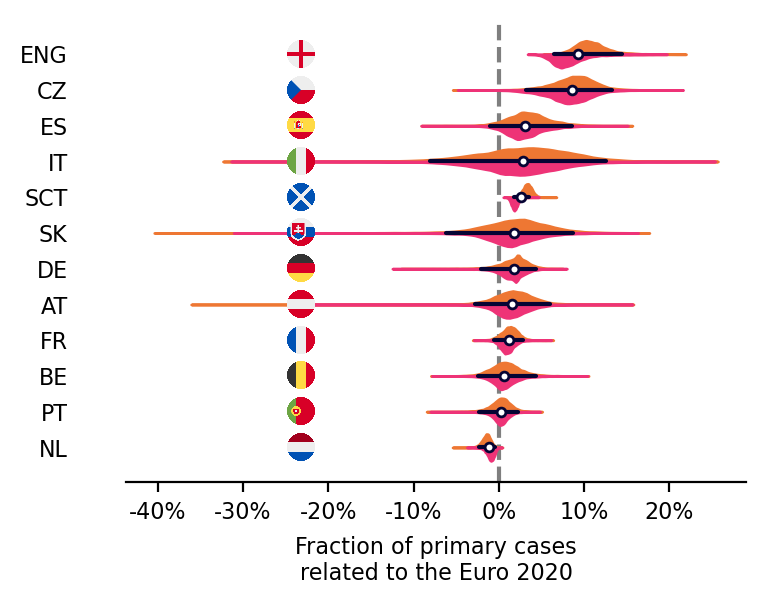

In [8]:
from covid19_soccer.plot.other import soccer_related_cases_overview

fig,ax = plt.subplots(1,1,figsize=(4,3))

soccer_related_cases_overview(
        ax,
        traces,
        models,
        dls,
        plot_flags=True,
        ypos_flags=-20,
        remove_outliers=True,
        bw=0.1,
        country_order=None,
        overall_effect_trace=None,
        vertical=True,
)
plt.show()